In [1]:
import torch
import torch.nn as nn

In [2]:
# GPT-2 small config
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 256, #1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

### - Calculating the training and validation set losses

In [3]:
with open('the-verdict.txt', mode='r') as f:
    text_data = f.read()

print(len(text_data))
print(text_data[:49]) # first 50 characters

20479
I HAD always thought Jack Gisburn rather a cheap 


In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print('Characters: ', total_characters)
print('Tokens: ', total_tokens)

Characters:  20479
Tokens:  5145


- Implementing the DataLoader (divide the dataset into training and validation sets)

In [5]:
from modules import GPTDatasetV1, create_dataloader_v1


# Trian/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(split_idx)
print(len(train_data))
print(len(val_data))

18431
18431
2048


In [6]:
# Split into Trian/validation sets

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuflle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuflle=False,
    num_workers=0
)

In [7]:
print(len(train_loader)) # 9 batches
print(len(val_loader)) # 1 batch

9
1


In [8]:
print(total_tokens * (1-train_ratio))
print(total_tokens * (train_ratio))

# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
    print('Not enough tokens for the training loader.'
          "Try to lower the 'GPT_CONFIG_124M context_length' or increase the training_ratio ")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M['context_length']:
    print('Not enough tokens for the validation loader.'
          "Try to lower the 'GPT_CONFIG_124M context_length' or decrease the validation_ratio ")

514.4999999999999
4630.5


In [9]:
# check if the data was loaded correctly

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))
# Train : input-target pairs [2 samples, 256 tokens]
# Validation : input-target pairs

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


c:\Users\pc\Desktop\LLM from scratch\modules.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input_ids[idx]) , torch.tensor(self.target_ids[idx])


In [10]:
# An optional check that the data was loaded correctly

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print('Training tokens:', train_tokens)
print('Validation tokens:', val_tokens)
print("All tokens:", train_tokens+val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- GPT Model

In [11]:
from modules import GPTModel

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Disable dropout during inference

In [12]:
# calculate the cross-entropy loss of a given batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# compute loss for a user specified number of batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data 
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


In [13]:
# if you have a machine with a CUDA supported GPU, the LLM will train on the GPU without making any changes
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model.to(device); # no assignment model = model.to(device) necessary for nn.Module classes

In [14]:
%%time

torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.981106758117676
CPU times: total: 42.8 s
Wall time: 23.7 s


In [15]:
# we can apply the same code on different dataset with different context_length (generizable)

### Training Loop For The LLM

In [16]:
# Calculate the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking 
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout disable
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [17]:
# import tiktoken
# from modules import text_to_token_ids, generate_text_simple, token_ids_to_text 

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # Eg if LLM supports only 5 tokens, and the context size is 10
        # then only the best 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) #[batch, n_tokens , vocab_size]

        # Focus only on the last time step (last token)
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softma to get probabilities
        probas= torch.softmax(logits, dim=-1) # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (btch, 1)

        # Append smapled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (btch, n_token+1)

    return idx


# convenience func thet we use to track whether th model improves during the training, its takes a text snippet (strat_context) as input, converts it into token IDs and feeds it to the LLM to generate a text
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' ')) # Compact print format
    model.train()


In [18]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [19]:

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):

    # Initialize lists to track losses and tokens seen
    train_losses = []
    val_losses = []
    track_tokens_seen = []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train() # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss grads
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in 
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f'Ep {epoch+1} (Step {global_step:06d}): '
                      f'Train loss {train_loss:.3f}, Val loss {val_loss:.3f}')
                
        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen


In [20]:
# Test with 10 epochs
import time 

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10 
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context='Every effort moves you', tokenizer=tokenizer
)
# every after each batches printing the training and validation loss
# huge number of params +120M
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes')

c:\Users\pc\Desktop\LLM from scratch\modules.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input_ids[idx]) , torch.tensor(self.target_ids[idx])


Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

In [22]:
# ValueError: too many values to unpack (expected 2)
# <!-- error at the end of training 10th epoch -->

In [ ]:
# As we can see, based on the results printed during the training, the training loss improves drastically, strarting with a value of 9.783 and and converging to 0.506

# Similatr to the training loss, we can see that the validation loss starts high (9.927) and decreases during the training. However, it never bocomes as small as the training set loss and remains at 6.325 after the A0th epoch.

# validation loss > training loss : indicate that the model is overfitting to the training data (cuz of the very small data)

In [ ]:
# # Another test with just 5 epochs
# import time 

# start_time = time.time()

# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# num_epochs = 5 
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context='Every effort moves you', tokenizer=tokenizer
# )
# # every after each batches printing the training and validation loss
# # huge number of params +120M
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f'Training completed in {execution_time_minutes:.2f} minutes')

c:\Users\pc\Desktop\LLM from scratch\modules.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input_ids[idx]) , torch.tensor(self.target_ids[idx])


Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

In [21]:
train_losses, val_losses, tokens_seen

([9.782992172241212,
  7.98503303527832,
  6.7534150123596195,
  6.113782119750977,
  5.524630165100097,
  5.3239333152771,
  4.761361694335937,
  4.460933542251587,
  3.8325411796569826,
  3.3516302585601805,
  2.861086368560791,
  2.347222995758057,
  2.0840754747390746,
  1.5214445829391479,
  1.2722728729248047,
  0.9998903870582581,
  0.7182631373405457,
  0.5058149099349976],
 [9.926935195922852,
  8.334564208984375,
  7.047619342803955,
  6.5733208656311035,
  6.489957332611084,
  6.387439250946045,
  6.3603034019470215,
  6.2576141357421875,
  6.196468353271484,
  6.139320373535156,
  6.111726760864258,
  6.137843132019043,
  6.179319381713867,
  6.175858497619629,
  6.1776227951049805,
  6.276617527008057,
  6.280826091766357,
  6.325016498565674],
 [512,
  3072,
  5632,
  8192,
  10752,
  13312,
  15872,
  18432,
  20992,
  23552,
  26112,
  28672,
  31232,
  33792,
  36352,
  38912,
  41472,
  44032])

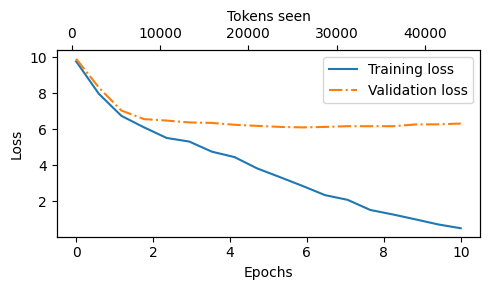

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, label="Validation loss", linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc="upper right")
    # only show integer labels
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) 

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny() # 2nd x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # invivible plot
    ax2.set_xlabel('Tokens seen')

    fig.tight_layout() # Adjust layout to make soom
    plt.savefig('loss-plot.pdf')
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Decodings Strategies To Control Randomness
- make sure that the model does not overffit too mush (make sure that the model predict new words not only memorize the training set)

In [23]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcuts): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [42]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




#### Decodings Strategy 1: Temperature Scaling
- Previously, inside generate_text_simple(), we always sampled the token with the highest proba as the next token using torch.argmax, also known as greedy decoding.
- To generate text with more variety we can replace the argmax with a function that samples from a proba distribution ()

In [28]:
# Example with small vocab
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v:k for k,v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [33]:
# Assume the LLM is given the start context "every effort moves you" and generate the following new logits tensor

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
) # n_cols = vocab_size

probas = torch.softmax(next_token_logits, dim=0)
print(probas)

next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


- to implement a probabilistic sampling process, we can now replace the argmax with the multinomial function in PyTorch

In [34]:
torch.manual_seed(123)

probas = torch.softmax(next_token_logits, dim=0)
print(probas)

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
7
toward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sammpled_ids = torch.bincount( torch.tensor(sample))
    for i, freq in enumerate(sammpled_ids):
        print(f"{freq} x {inverse_vocab[i]}") # how many times each token chosen

print_sampled_tokens(probas=probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [35]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5] # original, higher confidence and lower confedence

# calculate scaled probas
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
print(scaled_probas)

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]), tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22]), tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]


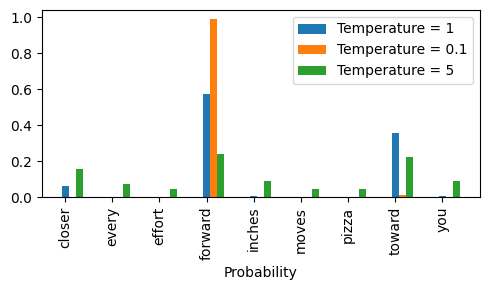

In [36]:
# Ploting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_xlabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

#### Decodings Strategy 2: Top-k Sampling

- Restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens

In [37]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
print(next_token_logits)

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])


In [38]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print('Top logits:', top_logits)
print('Top positions:', top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [39]:
top_logits[-1]

tensor(4.5100)

In [ ]:
# Replace all the other values which does not belong the top 3 with - inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [55]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### Merge Temperature Scaling and Top-k Sampling

In [44]:

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    # get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # filter logits with tok_k sampling
        if top_k is not None:
            # keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # apply softmax to get probas
            probs = torch.softmax(logits, dim=-1) # (batch size, context len)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
        
        # otherwise get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break # stop generating early if end-of-seq token is encountered

        idx = torch.cat((idx, idx_next), dim=1) # (batch_size, num_tokens+1)
    
    return idx


In [45]:
torch.manual_seed(123)

# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids('Every effort moves you', tokenizer),
#     max_new_tokens=25,
#     context_size=GPT_CONFIG_124M['context_length']
# )
# print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

# Output text:
#  Every effort moves you?"

# "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"


token_ids = generate(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)
print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


In [59]:
print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


### Loading and Saving Model Weights in PyTorch

In [46]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), 'model.pth')

In [47]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('model.pth'))
model.eval()

C:\Users\pc\AppData\Local\Temp\ipykernel_4592\1001060035.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcuts): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

- Saving optimizer state is also recommended

In [48]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_stat_dict": optimizer.state_dict()},
    "model_and_optimizer.pth"
)

In [50]:
checkpoint = torch.load("model_and_optimizer.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_stat_dict'])
model.train();

C:\Users\pc\AppData\Local\Temp\ipykernel_4592\4161416692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth")


### Loading Pre-Trained weights from OpenAI
- Download the weights from [kaggle](https://www.kaggle.com/datasets/xhlulu/openai-gpt2-weights)
- Or use gpt_download3.py code file: [gpt_download3.py](https://drive.google.com/file/d/1JX_DNJ9Xvty_ItciHhl_3TyOfahkGvvI/view)

In [61]:
# import tensorflow as tf
# import tqdm
# import numpy as np

# print("NumPy version: ", np.__version__)
# print('TensorFlow version:', tf.__version__)
# print('tqdm version:', tqdm.__version__)

In [56]:
# # hepls us download the 7 files from gpt2 124M
# from gpt_download3 import download_and_load_gpt2
# import tensorflow as tf
# import tqdm
# import numpy as np

# settings, params = download_and_load_gpt2(model_size='124M', models_dir='gpt2')


In [57]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [62]:
device

device(type='cpu')